# SQL Agent Examples

##### Common Setup

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain langsmith langchain-community langchain_openai langchain-experimental langgraph

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [2]:
_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "sql-agent"

In [ ]:
!wget https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db


--2024-10-31 20:21:41--  https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.134.207, 142.251.107.207, 74.125.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.134.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 913408 (892K) [application/octet-stream]
Saving to: ‘Chinook.db’

Chinook.db          100%[===================>] 892.00K  --.-KB/s    in 0.02s   

2024-10-31 20:21:41 (45.1 MB/s) - ‘Chinook.db’ saved [913408/913408]



In [6]:
from langchain_community.utilities import SQLDatabase

db_conn = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [ ]:
SQLDatabase

langchain_community.utilities.sql_database.SQLDatabase

In [4]:
from langchain_openai import ChatOpenAI
# from langchain_fireworks import ChatFireworks

chat = ChatOpenAI(model="gpt-4o-mini", temperature=0)

###### Test DB connection

In [7]:
print(f"{db_conn.dialect = }")
print(f"Usable tables: \n{db_conn.get_usable_table_names()}\n")
db_conn.run("SELECT * FROM Artist LIMIT 10;")

db_conn.dialect = 'sqlite'
Usable tables: 
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']



"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

## SQL Database Agent (LangSmith Cookbook)

Source: [LangSmith Cookbook](https://github.com/langchain-ai/langsmith-cookbook/blob/main/testing-examples/agent-evals-with-langgraph/langgraph_sql_agent_eval.ipynb)

### Prompts

In [ ]:
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

Execute the correct query with the appropriate tool."""


query_result_check_system = """You are grading the result of a SQL query from a DB.
- Check that the result is not empty.
- If it is empty, instruct the system to re-try!"""


query_gen_system = """
ROLE:
You are an agent designed to interact with a SQL database. You have access to tools for interacting with the database.
GOAL:
Given an input question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.
INSTRUCTIONS:
- Only use the below tools for the following operations.
- Only use the information returned by the below tools to construct your final answer.
- To start you should ALWAYS look at the tables in the database to see what you can query. Do NOT skip this step.
- Then you should query the schema of the most relevant tables.
- Write your query based upon the schema of the tables. You MUST double check your query before executing it.
- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
- You can order the results by a relevant column to return the most interesting examples in the database.
- Never query for all the columns from a specific table, only ask for the relevant columns given the question.
- If you get an error while executing a query, rewrite the query and try again.
- If the query returns a result, use check_result tool to check the query result.
- If the query result result is empty, think about the table schema, rewrite the query, and try again.
- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""


### Utilities

In [ ]:
# Define Tools

import json
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import tool


## SQL toolkit

toolkit = SQLDatabaseToolkit(db=db_conn, llm=chat)
tools = toolkit.get_tools()

## Query checking
query_check_prompt = ChatPromptTemplate([("system", query_check_system),
                                         ("user", "{query}")])
query_check = query_check_prompt | chat

@tool
def check_query_tool(query: str) -> str:
  """
  Use this tool to duble check if your query is correct before excuting it.
  """
  return query_check.invoke({"query": query}).content

tools.append(check_query_tool)


## Query result checking

query_result_check_prompt = ChatPromptTemplate(
    [("system", query_result_check_system),
     ("user","{query_result}")]
    )
query_result_check = query_result_check_prompt | chat

@tool
def check_result(query_result: str) -> str:
  """
  Use this tool to check the query result form the databse to confirm it is not empty and is relevant.
  """
  return query_result_check.invoke(query_result).content

tools.append(check_result)


# <class 'langchain_community.tools.sql_database.tool.QuerySQLDataBaseTool'>
# <class 'langchain_community.tools.sql_database.tool.InfoSQLDatabaseTool'>
# <class 'langchain_community.tools.sql_database.tool.ListSQLDatabaseTool'>
# <class 'langchain_community.tools.sql_database.tool.QuerySQLCheckerTool'>
# <class 'langchain_core.tools.structured.StructuredTool'>
# <class 'langchain_core.tools.structured.StructuredTool'>

In [ ]:
# Define State

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
# Define SQL Assistant

from langchain_core.runnables import Runnable, RunnableConfig

# Assistant
class Assistant:

  def __init__(self, runnable: Runnable):
    self.runnable = runnable

  def __call__(self, state: State, config: RunnableConfig):
    while True:
      state = {**state}
      result = self.runnable.invoke(state)

      if not result.tool_calls and (not result.content or isinstance(result.content, list) and not result.content[0].get("text")):
        messages = state["messages"] + [("user", "Respond with a real output.")]
        state = {**state, "messages": messages}
      else:
        break

    return {"messages": result}

query_gen_prompt = ChatPromptTemplate.from_messages([("system", query_gen_system),
                                                     ("placeholder", "{messages}")])
assistant_runnable = query_gen_prompt | chat.bind_tools(tools)


In [ ]:
# Graph Utilities

from langgraph.prebuilt.tool_node import ToolNode
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

def handle_tool_error(state) -> dict:
  error = state.get("error")
  tool_calls = state["messages"][-1].tool_calls

  return {"messages": [
      ToolMessage(content=f"Error: {repr(error)}\n please fix your mistake",
                  tool_call_id=tc[id])
      for tc in tool_calls]
          }

def create_tool_node_with_fallback(tools: list) -> dict:
  return ToolNode(tools).with_fallbacks(
      [RunnableLambda(handle_tool_error)], exception_key="error"
  )


def _print_event(event: dict, _printed: set, max_length=1500):

  current_state = event.get("dialog_state")

  if current_state:
    print(f"Currently in: {current_state[-1]}")

  message = event.get("messages")

  if message:
    if isinstance(message, list):
      message = message[-1]

    if message.id not in _printed:
      msg_repr = message.pretty_repr(html=True)
      if len(msg_repr) > max_length:
        msg_repr = msg_repr[:max_length]

      print(msg_repr)

      _printed.add(message.id)

### Graph

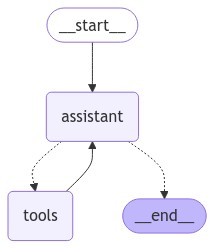

In [ ]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

builder = StateGraph(State)
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

builder.set_entry_point("assistant")
builder.add_conditional_edges("assistant", tools_condition, {"tools": "tools", END: END})
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Invoke

_printed = set()

thread = {"configurable": {"thread_id": "4"}}

question = "How many albums does the artist Led Zeppelin have?"

events = graph.stream({"messages": ("user", question)}, thread, stream_mode="values")

for event in events:
    _print_event(event, _printed)

================================ Human Message =================================

How many albums does the artist Led Zeppelin have?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_7GQf3hYJi5xJA0PQCzgUqqGb)
 Call ID: call_7GQf3hYJi5xJA0PQCzgUqqGb
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_2wUuJkglcV37xOitvkr8ojzg)
 Call ID: call_2wUuJkglcV37xOitvkr8ojzg
  Args:
    table_names: Album, Artist
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("Albu

**Note**: Check [LangSmith](https://www.langchain.com/langsmith) to see the details.

## SQL Agent (LangGraph)

Source: [LangGraph Tutorials](https://langchain-ai.github.io/langgraph/tutorials/sql-agent/)

#### Original Source code

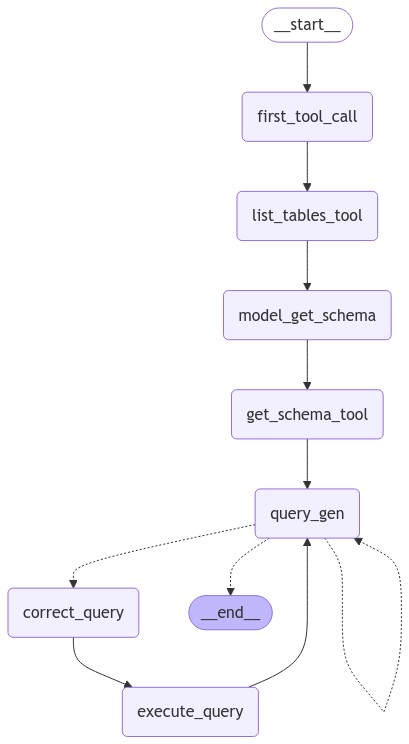

In [ ]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")


from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_openai import ChatOpenAI

toolkit = SQLDatabaseToolkit(db=db, llm=ChatOpenAI(model="gpt-4o"))
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")


from langchain_core.tools import tool


@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result


from langchain_core.prompts import ChatPromptTemplate

query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)
query_check = query_check_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [db_query_tool], tool_choice="required"
)

query_check.invoke({"messages": [("user", "SELECT * FROM Artist LIMIT 10;")]})


from typing import Annotated, Literal

from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages


# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# Define a new graph
workflow = StateGraph(State)


# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }


def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}


workflow.add_node("first_tool_call", first_tool_call)

# Add nodes for the first two tools
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)


# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""

    final_answer: str = Field(..., description="The final answer to the user")


# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set.
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(
    [SubmitFinalAnswer]
)


def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}


workflow.add_node("query_gen", query_gen_node)

# Add a node for the model to check the query before executing it
workflow.add_node("correct_query", model_check_query)

# Add node for executing the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))


# Define a conditional edge to decide whether to continue or end the workflow
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


# Specify the edges between the nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into a runnable
app = workflow.compile()


from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
messages = app.invoke(
    {"messages": [("user", "How many albums does the artist Led Zeppelin have?")]}
)
json_str = messages["messages"][-1].tool_calls[0]["args"]["final_answer"]
json_str

"I don't have enough information to determine how many albums Led Zeppelin has, as the available data does not include this artist."

In [ ]:
for event in app.stream(
    {"messages": [("user", "How many albums does the artist Led Zeppelin have?")]}
):
    print(event)

### Fixed version

**Note:** The original code is not ok, there is an issue with the query_gen chain that always calls the SubmitFinalAnswer tool instead response with a query the first time. As it nevers creates a query, it never call check_query node and never excute it.

So the code bellow include a fix.

##### Instructions

In [22]:
from langchain_groq import ChatGroq

In [34]:
QUERY_CHECK_INSTRUCTION = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""


QUERY_GEN_INSTRUCTION =  """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""

#### Graph

In [35]:
# Utilities

from langchain_community.utilities import SQLDatabase
from typing import Any
from langchain_core.runnables import RunnableWithFallbacks, RunnableLambda
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode


db_conn = SQLDatabase.from_uri("sqlite:///Chinook.db")


def handle_tool_error(state) -> dict:
  error = state.get("error")
  tool_calls = state("messages")[-1].tool_calls

  return {
      "messages": [
          ToolMessage(
              content=f"Error {repr(error)}\nplease fix your mistakes.",
              tool_call_id=tc["id"]
          )
          for tc in tool_calls
      ]
  }


def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
  """
  Create a ToolNode with a fallback to handle error and surface them to the agent.
  """

  return ToolNode(tools).with_fallbacks(
      [RunnableLambda(handle_tool_error)], exception_key="error"
  )

In [36]:
# Tools

from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


chat_1 = ChatGroq(model='llama-3.1-70b-versatile')
toolkit = SQLDatabaseToolkit(db=db_conn, llm=chat_1)
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name=="sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name=="sql_db_schema")


@tool
def db_query_tool(query: str) -> str:
  """
  Execute a SQL query againt the database and get back the result.
  If the query is not correct, an error message will be returned.
  If an error is returned, rewrite the query, check the query, and try again.
  """
  result = db_conn.run_no_throw(query)
  if not result:
    return "Error: Query failed. Please rewrite your query and try again"
  return result


# Query Check Chain
query_check_prompt = ChatPromptTemplate.from_messages([("system", QUERY_CHECK_INSTRUCTION), ("placeholder", "{messages}")])
chat_with_db_query_tool = ChatGroq(model='llama-3.1-70b-versatile').bind_tools([db_query_tool])
query_check = query_check_prompt | chat_with_db_query_tool


# Query Gen Chain

query_gen_prompt = ChatPromptTemplate.from_messages([("system", QUERY_GEN_INSTRUCTION), ("placeholder", "{messages}")])
chat_with_summit_final_answer_tool = ChatGroq(model='llama-3.1-70b-versatile')
query_gen_chain = query_gen_prompt | chat_with_summit_final_answer_tool


## This tool is not longer used in the fixed version

# class SubmitFinalAnswer(BaseModel):
#   """Submit the final answer to the user base on the query results."""
#   final_answer: str = Field(..., description="The final answer to the user")

In [37]:
# Define State

from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages]

In [38]:
# Define Nodes

from langchain_core.messages import AIMessage


list_tables = create_tool_node_with_fallback([list_tables_tool])

get_schema_tool_with_fallback = create_tool_node_with_fallback([get_schema_tool])

execute_query = create_tool_node_with_fallback([db_query_tool])


def first_tool_call(state: State) -> dict[str, list[AIMessage]]:

  tool_call = {"name": "sql_db_list_tables",
               "args": {},
               "id": "tool_abcd123"}

  return {"messages": [AIMessage(content="", tool_calls=[tool_call])]}


def model_check_query(state: State) -> dict[str, list[AIMessage]]:
  """
  Use this tool to dobule-check if your query is correct before executing it.
  """
  messages = state["messages"]

  response = query_check.invoke({"messages": messages[-1:]})
  return {"messages": [response]}


def model_get_schema(state: State):

  messages = state["messages"]

  chat_with_get_schema = ChatGroq(model='llama-3.1-70b-versatile').bind_tools(
      [get_schema_tool]
  )

  return {"messages": [chat_with_get_schema.invoke(messages)]}


def query_gen_node(state: State):
  message = query_gen_chain.invoke(state)
  return {"messages": [message]}

In [39]:
# Define conditional function

from typing import Literal
from langgraph.graph import END

def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]

    last_message = messages[-1]
    if last_message.content.startswith("Answer:"):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
      return "correct_query"

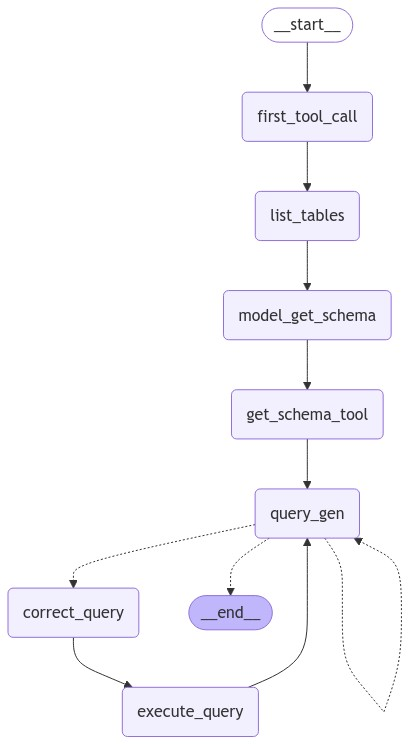

In [40]:
# Build Graph

from langgraph.graph import StateGraph, END, START
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod


builder = StateGraph(State)
builder.add_node(first_tool_call)
builder.add_node("list_tables", list_tables)
builder.add_node("get_schema_tool", get_schema_tool_with_fallback)
builder.add_node(model_get_schema)
builder.add_node("query_gen", query_gen_node)
builder.add_node("correct_query", model_check_query)
builder.add_node("execute_query", execute_query)

builder.add_edge(START, "first_tool_call")
builder.add_edge("first_tool_call", "list_tables")
builder.add_edge("list_tables", "model_get_schema")
builder.add_edge("model_get_schema", "get_schema_tool")
builder.add_edge("get_schema_tool", "query_gen")
builder.add_conditional_edges("query_gen", should_continue)
builder.add_edge("correct_query", "execute_query")
builder.add_edge("execute_query", "query_gen")

graph = builder.compile()

# View

display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)))

In [41]:
# Invoke

for event in graph.stream(
    {"messages": [("user", "How many albums does the artist Led Zeppelin have?")]}
):
    print(f"{event}\n\n")


{'first_tool_call': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, id='04037fe5-ea77-4086-a7e7-08d8b5ba0c2f', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}])]}}


{'list_tables': {'messages': [ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='2e279806-a124-474e-a448-75199b95caee', tool_call_id='tool_abcd123')]}}


{'model_get_schema': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3gf5', 'function': {'arguments': '{ "table_names": "Album" }', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 389, 'total_tokens': 407, 'completion_time': 0.072, 'prompt_time': 0.093940268, 'queue_time': 0.004517814000000009, 'total_time': 0.165940268}, 'model_name': 'llama-3.1-70b-versatile', 'system_fin

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

In [33]:
event["query_gen"]["messages"][-1].content

KeyError: 'query_gen'

**Note**: Check [LangSmith](https://www.langchain.com/langsmith) to see the details.



#### Test

In [20]:
print(f'Tables:\n{list_tables_tool.invoke("")}\n\n')
print(f'Artist Schema:\n{get_schema_tool.invoke("Artist")}\n')

query = "SELECT * FROM Artist LIMIT 10;"
print(f'Query "{query}" result:\n{db_query_tool.invoke(query)}')

Tables:
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track


Artist Schema:

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/

Query "SELECT * FROM Artist LIMIT 10;" result:
[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


In [ ]:
query = "SELECT * FROM Artist LIMIT 10;"
query_check.invoke({"messages": [("user", query)]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_15vvsZWrnZDWxjAbepdQ0glv', 'function': {'arguments': '{"query":"SELECT * FROM Artist LIMIT 10;"}', 'name': 'db_query_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 222, 'total_tokens': 242, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'stop', 'logprobs': None}, id='run-7748ac54-7ba6-4564-91e8-74e84afb5e09-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Artist LIMIT 10;'}, 'id': 'call_15vvsZWrnZDWxjAbepdQ0glv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 222, 'output_tokens': 20, 'total_tokens': 242, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [ ]:
from langchain_core.messages import HumanMessage

messages_raw = [HumanMessage(content='How many albums does the artist Led Zeppelin have?', additional_kwargs={}, response_metadata={}, id='1279d76f-8753-49a8-9558-e168480c2903'), AIMessage(content='', additional_kwargs={}, response_metadata={}, id='4c620133-e04b-4e10-81c0-761f92308ac6', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]), ToolMessage(content='Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track', name='sql_db_list_tables', id='36874d3a-44c6-44ab-aecf-5015a0c80846', tool_call_id='tool_abcd123'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_HZzN9rs7qbH54aEkRO9H52EP', 'function': {'arguments': '{"table_names":"Album, Artist"}', 'name': 'sql_db_schema'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 174, 'total_tokens': 192, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-af379125-9604-4d9b-9405-6c29c6288203-0', tool_calls=[{'name': 'sql_db_schema', 'args': {'table_names': 'Album, Artist'}, 'id': 'call_HZzN9rs7qbH54aEkRO9H52EP', 'type': 'tool_call'}], usage_metadata={'input_tokens': 174, 'output_tokens': 18, 'total_tokens': 192, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}), ToolMessage(content='\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/', name='sql_db_schema', id='ca309e7b-ea89-435c-8d05-3c27fd01f4e6', tool_call_id='call_HZzN9rs7qbH54aEkRO9H52EP')]


In [ ]:
query_gen_prompt.invoke({"messages": messages_raw})

In [ ]:
query_gen_chain.invoke({"messages": messages_raw})

## Custom SQL Agent

### Setup

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain langsmith langchain-community langchain_openai langchain-experimental langgraph

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [ ]:
_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "sql-agent"

OPENAI_API_KEY: ··········
LANGCHAIN_API_KEY: ··········


In [ ]:
!wget https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db


--2024-10-09 20:06:11--  https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.207, 74.125.26.207, 172.217.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 913408 (892K) [application/octet-stream]
Saving to: ‘Chinook.db’

Chinook.db          100%[===================>] 892.00K  --.-KB/s    in 0.01s   

2024-10-09 20:06:11 (60.5 MB/s) - ‘Chinook.db’ saved [913408/913408]



### Common

In [ ]:
from langchain_community.utilities import SQLDatabase
from langchain_openai import ChatOpenAI

import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

handler = logging.FileHandler('sql_agent.log')
handler.setLevel(logging.INFO)

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

logger.addHandler(handler)

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logger.info("Start SQL Agent")

# TODO: Consider to use the custom_table_info parammeter to pass the tables info
# If the table schemas doesn't doesn't change frequently it could be stored as a chaché
# In other case it could be generated as part of the agent setup. This is important
# the model need to now better the tables contents before select the relevant tables.
# For example, the table Eployes has the colum role but the model will don't now wiht roles
# it need to use to make a filter.

db_conn = SQLDatabase.from_uri("sqlite:///Chinook.db", lazy_table_reflection=True)
chat = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### Domine

In [ ]:
from pydantic import BaseModel, Field
from typing import List, Any, Dict

class Query(BaseModel):
  statement: str = Field(description="SQL query statment")
  reasoning: str = Field(description="Reasoning behind the query defination")
  is_valid: bool = Field(True, description="Indicates if the statment is sintatically valid")
  result: str = Field("", description="Query result")
  error: str = Field("", description="Error message if exists")

  @property
  def info(self) -> str:
    return (f"SQL query:\n{self.statement}\n\n"
    f"The reasoning you used to create that query was:\n{self.reasoning}\n\n"
    f"And this is the result you get:\n{self.result}")

  @property
  def error_info(self) -> str:
    return(f"Wrong SQL query:\n{self.statement}\n\n"
    f"The reasoning you used to create that query was:\n{self.reasoning}\n\n"
    f"And this is the error you got when excuted it: {self.error}")

### Instructions

In [ ]:
SELECT_RELEVANT_TABLES_INSTRUCTION ="""You are tasked to creating a list of tables from a SQL database.
The tables are: {tables_names}
Please choose the tables you consider relevant to anwer the user question below.
If you consider any table is relevant return with an empty list,
"""

GENERAL_QUERY_INSTRUCTIONS = """

When generating the query:

Output the SQL query that answers the input question without a tool call.

You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

Appart of provide the SQLite query statment, please includie in the response a short explanation of your reasoning to define the query"""


GENERATE_QUERY_INSTRUCTIONS = """You are a SQL expert with a strong attention to detail.
This is the information you have of the DB, it contains the table schema an some row examples:

{info}

Please create a syntactically correct SQLite query to answer the user question below.
""" + GENERAL_QUERY_INSTRUCTIONS


FIX_QUERY_INSTRUCTIONS = """You are a SQL expert with a strong attention to detail.
This is the information you have of the DB, it contains the table schema an some row examples:

{info}

You executed a query to answer an user question but something went wrong, this is the info you have:
{error_info}

Please fix the query or create a new syntactically correct SQLite query to answer the user question below.
""" + GENERAL_QUERY_INSTRUCTIONS


QUERY_CHECK_INSTRUCTION = """You are a SQL expert with a strong attention to detail.
Bellow there are a SQLite query statment and a breve resoning of how it was defined.

Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the stament and describe your reasoning in few words.
If there are no mistakes, just reproduce the original query and reasoning"""

GENERATE_ANSWER_INSTRUCTION = """You are an analyst and SQL expert. You run the following query to answer the question bellow.
{query_info}

Please answer the question ONLY with the information you above.
"""

In [ ]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

toolkit = SQLDatabaseToolkit(db=db_conn, llm=chat)
tools = toolkit.get_tools()

#### Tmp tests

##### metadata

In [ ]:
for tool in tools:
  print(f"{type(tool) = }\n{tool = }\n")

type(tool) = <class 'langchain_community.tools.sql_database.tool.QuerySQLDataBaseTool'>
tool = QuerySQLDataBaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x798ee8110850>)

type(tool) = <class 'langchain_community.tools.sql_database.tool.InfoSQLDatabaseTool'>
tool = InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x

In [ ]:
tables_names = db_conn.get_usable_table_names()

In [ ]:
print(f"{tables_names = }")

tables_names = ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


In [ ]:
dir(db_conn)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_all_tables',
 '_custom_table_info',
 '_engine',
 '_execute',
 '_get_sample_rows',
 '_get_table_indexes',
 '_ignore_tables',
 '_include_tables',
 '_indexes_in_table_info',
 '_inspector',
 '_max_string_length',
 '_metadata',
 '_sample_rows_in_table_info',
 '_schema',
 '_usable_tables',
 '_view_support',
 'dialect',
 'from_cnosdb',
 'from_databricks',
 'from_uri',
 'get_context',
 'get_table_info',
 'get_table_info_no_throw',
 'get_table_names',
 'get_usable_table_names',
 'run',
 'run_no_throw',
 'table_info']

In [ ]:
dir(db_conn._metadata)

['__annotations__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__visit_name__',
 '__weakref__',
 '_add_table',
 '_compiler_dispatch',
 '_fk_memos',
 '_generate_compiler_dispatch',
 '_init_items',
 '_original_compiler_dispatch',
 '_remove_table',
 '_schema_item_copy',
 '_schemas',
 '_sequences',
 '_set_parent',
 '_set_parent_with_dispatch',
 '_use_schema_map',
 'clear',
 'create_all',
 'create_drop_stringify_dialect',
 'dispatch',
 'drop_all',
 'info',
 'naming_convention',
 'reflect',
 'remove',
 'schema',
 'sorted_tables',
 'tables']

In [ ]:
relevant_tables = ['Album', 'Artist']

db_conn._metadata.reflect(
                bind=db_conn._engine,
                only=relevant_tables,
                schema=db_conn._schema,
            )
artist_table = db_conn._metadata.tables["Artist"]
print(f"{artist_table.name}: {artist_table.columns.keys()}")

Artist: ['ArtistId', 'Name']


In [ ]:
track_info = db_conn.get_table_info_no_throw(["Playlist", "Track"])
print(track_info)


CREATE TABLE "Playlist" (
	"PlaylistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("PlaylistId")
)

/*
3 rows from Playlist table:
PlaylistId	Name
1	Music
2	Movies
3	TV Shows
*/


CREATE TABLE "Track" (
	"TrackId" INTEGER NOT NULL, 
	"Name" NVARCHAR(200) NOT NULL, 
	"AlbumId" INTEGER, 
	"MediaTypeId" INTEGER NOT NULL, 
	"GenreId" INTEGER, 
	"Composer" NVARCHAR(220), 
	"Milliseconds" INTEGER NOT NULL, 
	"Bytes" INTEGER, 
	"UnitPrice" NUMERIC(10, 2) NOT NULL, 
	PRIMARY KEY ("TrackId"), 
	FOREIGN KEY("MediaTypeId") REFERENCES "MediaType" ("MediaTypeId"), 
	FOREIGN KEY("GenreId") REFERENCES "Genre" ("GenreId"), 
	FOREIGN KEY("AlbumId") REFERENCES "Album" ("AlbumId")
)

/*
3 rows from Track table:
TrackId	Name	AlbumId	MediaTypeId	GenreId	Composer	Milliseconds	Bytes	UnitPrice
1	For Those About To Rock (We Salute You)	1	1	1	Angus Young, Malcolm Young, Brian Johnson	343719	11170334	0.99
2	Balls to the Wall	2	2	1	None	342562	5510424	0.99
3	Fast As a Shark	3	2	1	F. Baltes, S. Kauf

### States

In [ ]:
import operator
from typing_extensions import TypedDict
from typing import Annotated


class InputState(TypedDict):
  question: str
  max_attempts: int

class OutputState(TypedDict):
  answer: str
  error_message: str


class OverallState(TypedDict):
  question: str
  max_attempts: int
  attempts: Annotated[int, operator.add]
  answer: str
  error_message: str
  tables_info: str
  resoning: str
  queries: Annotated[List[Query], operator.add]

### Nodes

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.errors import NodeInterrupt


MAX_ATTEMPTS_DEFAULT = 1
INVALID_QUESTION_ERROR = "The quesiton is not related to the database"
REACH_OUT_MAX_ATTEMPTS_ERROR = "The system reach out the attempts limits before get the information."


def select_relevant_schemas(state: InputState) -> OverallState:
  logger.info('### select_relevant_schemas ###')

  max_attempts = state.get("max_attempts", 0)
  state["max_attempts"] = max_attempts if max_attempts > 0 else MAX_ATTEMPTS_DEFAULT

  tables_names = db_conn.get_usable_table_names()
  question = state["question"]

  instructions = SystemMessage(content=SELECT_RELEVANT_TABLES_INSTRUCTION.format(tables_names=tables_names))
  prompt = [instructions] + [HumanMessage(content=question)]
  structured_chat = chat.with_structured_output(list)

  relevant_tables = structured_chat.invoke(prompt).get('iterable')
  logger.info(f"{relevant_tables = }")

  if not relevant_tables:
    return {"error_message": INVALID_QUESTION_ERROR}

  tables_info = db_conn.get_table_info(relevant_tables)

  return {"tables_info": tables_info, "attempts": 1, **state}


class GenQueryResponse(BaseModel):
  statement: str = Field(description="Query stament to be run later in the DB")
  reasoning: str = Field(description="Reasoning used to define the query")


def generate_query(state: OverallState) -> OverallState:
  logger.info("### generate_query ###")

  question = state["question"]
  tables_info = state["tables_info"]
  queries = state.get("queries")

  # Gen query
  instructions = (GENERATE_QUERY_INSTRUCTIONS.format(info=tables_info)
  if not queries
  else FIX_QUERY_INSTRUCTIONS.format(info=tables_info, error_info=queries[-1].error_info))

  generator_prompt = ([SystemMessage(content=instructions)] + [HumanMessage(content=question)])
  generator = chat.with_structured_output(GenQueryResponse)
  gen_response = generator.invoke(generator_prompt)

  # Check query
  checker_prompt = (
      [SystemMessage(content=QUERY_CHECK_INSTRUCTION)] +
      [AIMessage(content=f"SQLite query: {gen_response.statement}\nReasoning: {gen_response.reasoning}")]
      )
  checker = chat.with_structured_output(GenQueryResponse)
  checker_response = checker.invoke(checker_prompt)

  was_corrected = gen_response.statement != checker_response.statement

  final_reasoning = (gen_response.reasoning  +
                     "" if not was_corrected else f"First: {gen_response.reasoning}\nCorrection: {checker_response.reasoning}")

  query = Query(statement=checker_response.statement, reasoning=final_reasoning)
  logger.info(query.info)

  return {"queries": [query]}


def excute_query(state: OverallState) -> OverallState:
  logger.info("### excute_query ###")

  attempts = state["attempts"]
  max_attempts = state["max_attempts"]

  logger.info(f"Attempt {attempts} of {max_attempts}")

  query = state["queries"][-1]

  try:
    query.result = db_conn.run(query.statement)

  except Exception as e:
    query.error = str(e)
    query.is_valid= False

    logger.info(query.error_info)

    if attempts >= max_attempts:
      logger.info(f"Reach out max attempts")
      return {"error_message": REACH_OUT_MAX_ATTEMPTS_ERROR}

  return {"attempts": 1}


def gen_answer(state: OverallState) -> OutputState:
  logger.info("### gen_answer ###")

  if error_message := state.get("error_message"):
    return {"error_message": error_message}

  query = state["queries"][-1]

  generate_answer_instruction = GENERATE_ANSWER_INSTRUCTION.format(query_info= query.info)

  prompt = (
      [SystemMessage(content=generate_answer_instruction)] +
      [HumanMessage(content=state["question"])]
      )

  response = chat.invoke(prompt)

  return {"answer": response.content}

### Conditional Function (Routers)



In [ ]:
from typing import Literal
from langgraph.graph import END


def check_question(state: OverallState) -> Literal["generate_query", "gen_answer"]:
  if state.get("error_message") == INVALID_QUESTION_ERROR:
    return "gen_answer"
  return "generate_query"


def router(state: OverallState) -> Literal["generate_query", "gen_answer"]:
  query = state["queries"][-1]

  return "gen_answer" if query.result else "generate_query"

### Build Graph

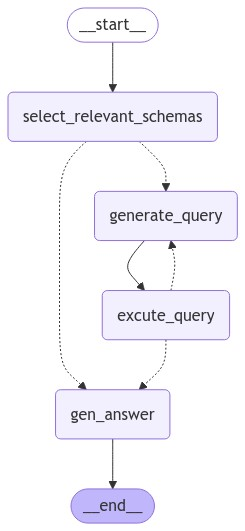

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image

builder = StateGraph(OverallState, input=InputState, output=OutputState)
builder.add_node(select_relevant_schemas)
builder.add_node(generate_query)
builder.add_node(excute_query)
builder.add_node(gen_answer)

builder.add_edge(START, "select_relevant_schemas")
builder.add_conditional_edges("select_relevant_schemas", check_question)
builder.add_edge("generate_query", "excute_query")
builder.add_conditional_edges("excute_query", router)
builder.add_edge("gen_answer", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)


# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Tests

#### Happy Path

In [ ]:
thread_1 = {"configurable": {"thread_id": "1"}}
question = "How many albums does the artist Led Zeppelin have?"
response = graph.invoke({"question": question, "max_attempts": 2}, thread_1)
print(f"\n{response = }")

### select_relevant_schemas ###
tables_names = ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
relevant_tables = ['Album', 'Artist']
### generate_query ###
gen_response = GenQueryResponse(statement="SELECT COUNT(*) AS AlbumCount FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'Led Zeppelin')", reasoning='To find out how many albums the artist Led Zeppelin has, I first need to get the ArtistId for Led Zeppelin from the Artist table. Then, I can count the number of albums in the Album table that correspond to that ArtistId. The query counts the albums and limits the results to just the count.')
checker_response = GenQueryResponse(statement="SELECT COUNT(*) AS AlbumCount FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'Led Zeppelin')", reasoning='To find out how many albums the artist Led Zeppelin has, I first need to get the ArtistId for Led Zeppelin from the Arti

In [ ]:
for state in graph.get_state_history(thread_1):
  print(state)

StateSnapshot(values={'question': 'How many albums does the artist Led Zeppelin have?', 'max_attempts': 2, 'attempts': 1, 'answer': 'Led Zeppelin has 14 albums.', 'tables_info': '\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/', 'queries': [Query(statement="SELECT COUNT(*) AS AlbumCount FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'Led Zeppelin')", reasoning='To find out how many albums the artist Led Zeppelin has, I first need to get th

**Traceback**: https://smith.langchain.com/public/349b4951-82cc-4948-8ca1-1c4346cd94c4/r

#### Question out of context

In [ ]:
thread_2 = {"configurable": {"thread_id": "2"}}
question = "How many pets were adopted on 2023?"

response = graph.invoke({"question": question}, thread_2)
print(f"\n{response = }")

{'question': 'How many pets were adopted on 2023?', 'attempts': 0, 'queries': []} 


### select_relevant_schemas ###
tables_names = ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
relevant_tables = None
{'question': 'How many pets were adopted on 2023?', 'attempts': 0, 'error_message': 'The quesiton is not related to the database', 'queries': []} 


### gen_answer ###
{'question': 'How many pets were adopted on 2023?', 'attempts': 0, 'error_message': 'The quesiton is not related to the database', 'queries': []} 




**Traceback**: https://smith.langchain.com/public/f5afddc6-c85f-448b-b786-0005a01db334/r

#### Execute failed - Retry query generation

In [ ]:
thread_3 = {"configurable": {"thread_id": "3"}}
question = "How many albums does the artist Led Zeppelin have?"

graph.invoke({"question": question, "max_attempts": 2}, thread_3, interrupt_before=["generate_query"])

# Force to execute a bad query

WRONG_STATEMENT = "SELECT COUNT AS AlbumCount FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name == 'Led Zeppelin')"
REASONING = 'To find out how many albums the artist Led Zeppelin has, I first need to get the ArtistId for Led Zeppelin from the Artist table. Then, I can count the number of albums in the Album table that correspond to that ArtistId. The query counts the albums and limits the results to just the count.'

bad_query = Query(statement=WRONG_STATEMENT, reasoning=REASONING)
graph.update_state(thread_3, {"queries": [bad_query]}, as_node="generate_query")

response = graph.invoke(None, thread_3)
print(f"\n{response = }")

### select_relevant_schemas ###
tables_names = ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
relevant_tables = ['Album', 'Artist']
### excute_query ###
error: (sqlite3.OperationalError) no such column: COUNT
[SQL: SELECT COUNT AS AlbumCount FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name == 'Led Zeppelin')]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
### generate_query ###
gen_response = GenQueryResponse(statement="SELECT COUNT(*) AS AlbumCount FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'Led Zeppelin')", reasoning='To find out how many albums the artist Led Zeppelin has, I first need to get the ArtistId for Led Zeppelin from the Artist table. Then, I can count the number of albums in the Album table that correspond to that ArtistId. The query counts the albums and limits the results to just the count.')
checker_response = GenQueryResponse(s

**Traceback**:

- Before `generate_query`: https://smith.langchain.com/public/98e34f8d-875f-4075-aef9-610edeff8e78/r

- Insert bad query: https://smith.langchain.com/public/db406c99-a556-4c58-9b68-6b76e72e9e24/r

- Continue execution: https://smith.langchain.com/public/50f47b56-bc49-40e0-a55a-961b910334ab/r

#### Reach out max_attempts

In [ ]:
thread_4 = {"configurable": {"thread_id": "4"}}
question = "How many albums does the artist Led Zeppelin have?"

graph.invoke({"question": question, "max_attempts": 1}, thread_4, interrupt_before=["generate_query"])

# Force to execute a bad query

WRONG_STATEMENT = "SELECT COUNT AS AlbumCount FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name == 'Led Zeppelin')"
REASONING = 'To find out how many albums the artist Led Zeppelin has, I first need to get the ArtistId for Led Zeppelin from the Artist table. Then, I can count the number of albums in the Album table that correspond to that ArtistId. The query counts the albums and limits the results to just the count.'

bad_query = Query(statement=WRONG_STATEMENT, reasoning=REASONING)
graph.update_state(thread_4, {"queries": [bad_query]}, as_node="generate_query")

response = graph.invoke(None, thread_4)
print(f"\n{response = }")

### select_relevant_schemas ###
tables_names = ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']
relevant_tables = ['Album', 'Artist']
### excute_query ###
error: (sqlite3.OperationalError) no such column: COUNT
[SQL: SELECT COUNT AS AlbumCount FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name == 'Led Zeppelin')]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
### generate_query ###
### excute_query ###
error: (sqlite3.OperationalError) no such column: COUNT
[SQL: SELECT COUNT AS AlbumCount FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name == 'Led Zeppelin')]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
### generate_query ###
gen_response = GenQueryResponse(statement="SELECT COUNT(*) AS AlbumCount FROM Album WHERE ArtistId = (SELECT ArtistId FROM Artist WHERE Name = 'Led Zeppelin')", reasoning='To find out how many albums the artist Led Zeppel

**Traceback**:

- Before `generate_query`: https://smith.langchain.com/public/11dedb35-c933-4620-8a7d-483392e3570b/r

- Insert bad query: https://smith.langchain.com/public/356940ab-8e6e-4211-a56a-d89b15f5e538/r

- Continue execution: https://smith.langchain.com/public/9124e0ba-386d-40f8-9d02-0388a15f1161/r

### Client

In [ ]:
import uuid


def run_client(question="", max_attempts= 1):
  print("### Start Client ###\n")

  question = question if question else input("Question: ")
  config = {"configurable": {"thread_id": str(uuid.uuid4())}}

  user_input = {"question": question, "max_attempts": max_attempts}

  response = graph.invoke(user_input, config)

  if answer := response.get("answer"):
    print("🙌", answer)
    return

  if error := response.get("error_message"):
    print("\n🙈", error)

##### Tests

In [ ]:
run_client("Which sales agent made the most in sales in 2009?", max_attempts=3)

### Start Client ###

🙌 The sales agent who made the most in sales in 2009 is Margaret Park, with total sales of 10.89.


**Traceback:** https://smith.langchain.com/public/e0582ba1-9ad1-4efe-b766-2e7f5f466a4f/r

⚠️ This result is potencially wrong. According to LangGraph docs the answer is: Steve Johnson made the most sales in 2009

⚠️ It failed with only one attempt -> [Error Traceback](https://smith.langchain.com/public/21132adb-b6cd-4426-a094-3d4a97a47bea/r)

In [ ]:
run_client("What was the most purchased track of 2013?")

### Start Client ###

🙌 The most purchased track of 2013 was "Hot Girl."


**Traceback:** https://smith.langchain.com/public/c641f246-1568-41ba-9989-1b8661ff12cf/r

In [ ]:
run_client("Which country's customers spent the most? And how much did they spend?")

### Start Client ###

🙌 The customers from the USA spent the most, with a total of 523.06.


**Traceback:** https://smith.langchain.com/public/aa22f688-7459-4c98-9c0d-f7bb7fcb4728/r

In [ ]:
run_client("What is the total price for the album “Big Ones”?")

### Start Client ###

🙌 The total price for the album "Big Ones" is 9.9.


**Traceback:** https://smith.langchain.com/public/35c3f310-bf53-454a-915f-a278a04e9db6/r

⚠️ This result is potencially wrong. According to LangGraph docs the answer is: The total price for the album 'Big Ones' is 14.85

## References

- [Doubts Chat](https://sl.bing.net/gDQcr8NpA9A)
- [with_fallbacks](https://python.langchain.com/api_reference/langchain/agents/langchain.agents.agent.ExceptionTool.html#langchain.agents.agent.ExceptionTool.with_fallbacks)
- [How to define SQL tools by hand](https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/agent_toolkits/sql/toolkit.py#L92)
- [Bind Tools](https://python.langchain.com/api_reference/openai/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html#langchain_openai.chat_models.base.ChatOpenAI.bind_tools)